In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [25]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [26]:
class DNN_4(nn.Module):
    def __init__(self, input_dim,hidden_units1,hidden_units2,hidden_units3,hidden_units4,dropout1,dropout2,dropout3,dropout4):
        super(DNN_4, self).__init__()
        self.layer1 = nn.Linear(input_dim,hidden_units1)
        self.layer2 = nn.Linear(hidden_units1,hidden_units2)
        self.layer3 = nn.Linear(hidden_units2, hidden_units3)
        self.layer4 = nn.Linear(hidden_units3, hidden_units4)
        self.output_layer = nn.Linear(hidden_units4, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)


        self.bn1 = nn.BatchNorm1d(hidden_units1)
        self.bn2 = nn.BatchNorm1d(hidden_units2)
        self.bn3 = nn.BatchNorm1d(hidden_units3)
        self.bn4 = nn.BatchNorm1d(hidden_units4)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [27]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [28]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    hidden_units1 = trial.suggest_int("hidden_units1", 216, 512, step=2)
    hidden_units2 = trial.suggest_int("hidden_units2", 128, 216, step=2)
    hidden_units3 = trial.suggest_int("hidden_units3", 64, 128, step=2)
    hidden_units4 = trial.suggest_int("hidden_units4", 4, 64, step=2)
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    dropout3 = trial.suggest_float("dropout3", 0, 0.5, step=0.05)
    dropout4 = trial.suggest_float("dropout4", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整

    # モデル定義
    model = DNN_4(
        input_dim=X_train_tensor.shape[1],
        hidden_units1=hidden_units1,
        hidden_units2=hidden_units2,
        hidden_units3=hidden_units3,
        hidden_units4=hidden_units4,
        dropout1=dropout1,
        dropout2=dropout2,
        dropout3=dropout3,
        dropout4=dropout4
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val).item()
                predictions = (val_outputs >= 0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [29]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-11-29 18:13:13,345] A new study created in memory with name: no-name-267bc70e-86b2-41bb-a61a-907c7adbb067
/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:13:28,580] Trial 0 finished with value: 0.363456459310993 and parameters: {'hidden_units1': 242, 'hidden_units2': 190, 'hidden_units3': 110, 'hidden_units4': 62, 'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.4, 'drop

Early stopping at epoch 30
Final MCC: 0.3635


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:13:41,855] Trial 1 finished with value: 0.0 and parameters: {'hidden_units1': 430, 'hidden_units2': 216, 'hidden_units3': 116, 'hidden_units4': 4, 'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.25, 'dropout4': 0.30000000000000004, 'learning_rate': 0.0020878048803826617, 'weight_decay': 0.009939302589013248}. Best is trial 0 with 

Early stopping at epoch 27
Final MCC: 0.0000


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:13:58,601] Trial 2 finished with value: 0.13562424637140266 and parameters: {'hidden_units1': 414, 'hidden_units2': 128, 'hidden_units3': 84, 'hidden_units4': 62, 'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'dropout3': 0.45, 'dropout4': 0.05, 'learning_rate': 0.00044219707028402623, 'weight_decay': 0.004818837977617114}. Bes

Early stopping at epoch 33
Final MCC: 0.1356


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:14:13,719] Trial 3 finished with value: 0.09051256444028409 and parameters: {'hidden_units1': 354, 'hidden_units2': 202, 'hidden_units3': 120, 'hidden_units4': 8, 'dropout1': 0.1, 'dropout2': 0.45, 'dropout3': 0.25, 'dropout4': 0.35000000000000003, 'learning_rate': 0.00029923374388035156, 'weight_decay': 2.2623035549130652e-05}. B

Early stopping at epoch 30
Final MCC: 0.0905


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:14:24,544] Trial 4 finished with value: 0.1438102961529 and parameters: {'hidden_units1': 226, 'hidden_units2': 206, 'hidden_units3': 96, 'hidden_units4': 46, 'dropout1': 0.05, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.5, 'learning_rate': 0.0016005227166539136, 'weight_decay': 0.0001379715227584699}. Best is trial 0 with va

Early stopping at epoch 21
Final MCC: 0.1438


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:14:25,063] Trial 5 pruned. 
[I 2024-11-29 18:14:25,671] Trial 6 pruned. 
[I 2024-11-29 18:14:26,186] Trial 7 pruned. 
[I 2024-11-29 18:14:35,975] Trial 8 finished with value: 0.09529760045804525 and parameters: {'hidden_units1': 216, 'hidden_units2': 166, 'hidden_units3': 88, 'hidden_units4': 4, 'dropout1': 0.05, 'dropout2': 0.05,

Early stopping at epoch 18
Final MCC: 0.0953


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:14:36,545] Trial 9 pruned. 
[I 2024-11-29 18:14:58,874] Trial 10 finished with value: 0.20308316053730185 and parameters: {'hidden_units1': 510, 'hidden_units2': 186, 'hidden_units3': 128, 'hidden_units4': 26, 'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'dropout3': 0.4, 'dropout4': 0.0, 'learning_rate': 0.0001161957440441129

Early stopping at epoch 43
Final MCC: 0.2031


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:15:22,831] Trial 11 finished with value: 0.22913681256205473 and parameters: {'hidden_units1': 512, 'hidden_units2': 186, 'hidden_units3': 128, 'hidden_units4': 24, 'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'dropout3': 0.4, 'dropout4': 0.0, 'learning_rate': 0.00010893792652008008, 'weight_decay': 0.0012558068310823053}. Be

Early stopping at epoch 47
Final MCC: 0.2291


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:15:39,550] Trial 12 finished with value: 0.13756104954577136 and parameters: {'hidden_units1': 512, 'hidden_units2': 186, 'hidden_units3': 104, 'hidden_units4': 20, 'dropout1': 0.35000000000000003, 'dropout2': 0.35000000000000003, 'dropout3': 0.35000000000000003, 'dropout4': 0.2, 'learning_rate': 0.00010601285247812774, 'weight_de

Early stopping at epoch 33
Final MCC: 0.1376


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:16:04,639] Trial 13 finished with value: 0.15991298293946796 and parameters: {'hidden_units1': 322, 'hidden_units2': 188, 'hidden_units3': 126, 'hidden_units4': 40, 'dropout1': 0.5, 'dropout2': 0.35000000000000003, 'dropout3': 0.0, 'dropout4': 0.0, 'learning_rate': 0.00015581626499282881, 'weight_decay': 0.0009087965334196711}. Be

Early stopping at epoch 53
Final MCC: 0.1599


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:16:17,077] Trial 14 finished with value: 0.17728105208558367 and parameters: {'hidden_units1': 478, 'hidden_units2': 154, 'hidden_units3': 112, 'hidden_units4': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dropout3': 0.35000000000000003, 'dropout4': 0.1, 'learning_rate': 0.00018797454816690362, 'weight_decay': 0.00052695

Early stopping at epoch 24
Final MCC: 0.1773


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:16:17,674] Trial 15 pruned. 
[I 2024-11-29 18:16:18,159] Trial 16 pruned. 
[I 2024-11-29 18:16:18,761] Trial 17 pruned. 
[I 2024-11-29 18:16:19,293] Trial 18 pruned. 
[I 2024-11-29 18:16:43,294] Trial 19 finished with value: 0.22855609375122193 and parameters: {'hidden_units1': 260, 'hidden_units2': 156, 'hidden_units3': 98, 'hidd

Early stopping at epoch 49
Final MCC: 0.2286


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:16:58,046] Trial 20 finished with value: 0.15456669461361328 and parameters: {'hidden_units1': 468, 'hidden_units2': 178, 'hidden_units3': 110, 'hidden_units4': 26, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.45, 'learning_rate': 0.00018094781406556711, 'weight_decay': 0.0016761738538791473}. Best is trial 0 w

Early stopping at epoch 31
Final MCC: 0.1546


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:17:26,113] Trial 21 finished with value: 0.16989681498993767 and parameters: {'hidden_units1': 258, 'hidden_units2': 154, 'hidden_units3': 96, 'hidden_units4': 36, 'dropout1': 0.25, 'dropout2': 0.45, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00010604949325367609, 'weight_decay': 0.0089336

Early stopping at epoch 55
Final MCC: 0.1699


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:17:42,598] Trial 22 finished with value: 0.07809849151323855 and parameters: {'hidden_units1': 262, 'hidden_units2': 154, 'hidden_units3': 88, 'hidden_units4': 12, 'dropout1': 0.15000000000000002, 'dropout2': 0.45, 'dropout3': 0.30000000000000004, 'dropout4': 0.25, 'learning_rate': 0.00015660247342243417, 'weight_decay': 0.0049876

Early stopping at epoch 35
Final MCC: 0.0781


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:17:43,112] Trial 23 pruned. 
[I 2024-11-29 18:17:43,659] Trial 24 pruned. 
[I 2024-11-29 18:18:04,057] Trial 25 finished with value: 0.23412458044872408 and parameters: {'hidden_units1': 288, 'hidden_units2': 192, 'hidden_units3': 120, 'hidden_units4': 36, 'dropout1': 0.15000000000000002, 'dropout2': 0.4, 'dropout3': 0.35000000000

Early stopping at epoch 40
Final MCC: 0.2341


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:18:19,202] Trial 26 finished with value: 0.1800840553936537 and parameters: {'hidden_units1': 286, 'hidden_units2': 192, 'hidden_units3': 120, 'hidden_units4': 18, 'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0001484146551211982, 'weight_deca

Early stopping at epoch 30
Final MCC: 0.1801


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:18:31,210] Trial 27 finished with value: 0.1438102961529 and parameters: {'hidden_units1': 334, 'hidden_units2': 182, 'hidden_units3': 122, 'hidden_units4': 28, 'dropout1': 0.1, 'dropout2': 0.4, 'dropout3': 0.35000000000000003, 'dropout4': 0.05, 'learning_rate': 0.0004065390222674427, 'weight_decay': 0.0005981117963201918}. Best i

Early stopping at epoch 24
Final MCC: 0.1438


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:18:31,791] Trial 28 pruned. 
[I 2024-11-29 18:18:32,250] Trial 29 pruned. 
[I 2024-11-29 18:18:32,688] Trial 30 pruned. 
[I 2024-11-29 18:18:50,901] Trial 31 finished with value: 0.15635070158909536 and parameters: {'hidden_units1': 276, 'hidden_units2': 172, 'hidden_units3': 120, 'hidden_units4': 38, 'dropout1': 0.2, 'dropout2': 

Early stopping at epoch 39
Final MCC: 0.1564


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:19:07,526] Trial 32 finished with value: 0.09213462593266854 and parameters: {'hidden_units1': 308, 'hidden_units2': 192, 'hidden_units3': 106, 'hidden_units4': 34, 'dropout1': 0.25, 'dropout2': 0.5, 'dropout3': 0.35000000000000003, 'dropout4': 0.35000000000000003, 'learning_rate': 0.00013892626473754164, 'weight_decay': 0.0064543

Early stopping at epoch 33
Final MCC: 0.0921


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:19:37,884] Trial 33 finished with value: 0.33428792028904475 and parameters: {'hidden_units1': 268, 'hidden_units2': 128, 'hidden_units3': 128, 'hidden_units4': 60, 'dropout1': 0.35000000000000003, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.2, 'learning_rate': 0.00013119184657981876, 'weight_decay': 0.0007773085136006188}. Be

Early stopping at epoch 62
Final MCC: 0.3343


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:20:03,569] Trial 34 finished with value: 0.1537350115670227 and parameters: {'hidden_units1': 334, 'hidden_units2': 132, 'hidden_units3': 128, 'hidden_units4': 60, 'dropout1': 0.35000000000000003, 'dropout2': 0.4, 'dropout3': 0.45, 'dropout4': 0.2, 'learning_rate': 0.00014033850932850537, 'weight_decay': 0.0008184935393254179}. Be

Early stopping at epoch 53
Final MCC: 0.1537


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:20:04,126] Trial 35 pruned. 
[I 2024-11-29 18:20:04,697] Trial 36 pruned. 
[I 2024-11-29 18:20:05,259] Trial 37 pruned. 
[I 2024-11-29 18:20:23,564] Trial 38 finished with value: 0.26613248971641873 and parameters: {'hidden_units1': 272, 'hidden_units2': 172, 'hidden_units3': 122, 'hidden_units4': 44, 'dropout1': 0.300000000000000

Early stopping at epoch 36
Final MCC: 0.2661


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:20:24,094] Trial 39 pruned. 
[I 2024-11-29 18:20:24,632] Trial 40 pruned. 
[I 2024-11-29 18:20:25,179] Trial 41 pruned. 
[I 2024-11-29 18:20:25,780] Trial 42 pruned. 
[I 2024-11-29 18:20:46,495] Trial 43 finished with value: 0.1721463019918058 and parameters: {'hidden_units1': 306, 'hidden_units2': 170, 'hidden_units3': 126, 'hidd

Early stopping at epoch 40
Final MCC: 0.1721


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:21:08,988] Trial 44 finished with value: 0.08571428571428572 and parameters: {'hidden_units1': 246, 'hidden_units2': 188, 'hidden_units3': 122, 'hidden_units4': 16, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.2, 'learning_rate': 0.00013103885861646733, 'weight_decay': 0.000736751963561903}. Be

Early stopping at epoch 44
Final MCC: 0.0857


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:21:09,589] Trial 45 pruned. 
[I 2024-11-29 18:21:10,155] Trial 46 pruned. 
[I 2024-11-29 18:21:10,715] Trial 47 pruned. 
[I 2024-11-29 18:21:11,300] Trial 48 pruned. 
[I 2024-11-29 18:21:11,843] Trial 49 pruned. 
[I 2024-11-29 18:21:12,388] Trial 50 pruned. 
[I 2024-11-29 18:21:34,968] Trial 51 finished with value: 0.2169874359905

Early stopping at epoch 46
Final MCC: 0.2170


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:21:59,107] Trial 52 finished with value: 0.20191135200894691 and parameters: {'hidden_units1': 250, 'hidden_units2': 174, 'hidden_units3': 98, 'hidden_units4': 42, 'dropout1': 0.25, 'dropout2': 0.4, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00012088727382362368, 'weight_decay': 0.00466969

Early stopping at epoch 48
Final MCC: 0.2019


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:21:59,611] Trial 53 pruned. 
[I 2024-11-29 18:22:28,452] Trial 54 finished with value: 0.21900322682555096 and parameters: {'hidden_units1': 224, 'hidden_units2': 136, 'hidden_units3': 84, 'hidden_units4': 46, 'dropout1': 0.25, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.25, 'learning_rate': 0.00012148876316585342, 'weight_de

Early stopping at epoch 58
Final MCC: 0.2190


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:22:29,033] Trial 55 pruned. 
[I 2024-11-29 18:22:29,639] Trial 56 pruned. 
[I 2024-11-29 18:22:57,268] Trial 57 finished with value: 0.2037191993564762 and parameters: {'hidden_units1': 452, 'hidden_units2': 170, 'hidden_units3': 114, 'hidden_units4': 24, 'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'dropout3': 0.300000000000

Early stopping at epoch 57
Final MCC: 0.2037


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:22:57,752] Trial 58 pruned. 
[I 2024-11-29 18:22:58,260] Trial 59 pruned. 
[I 2024-11-29 18:22:58,800] Trial 60 pruned. 
[I 2024-11-29 18:22:59,292] Trial 61 pruned. 
[I 2024-11-29 18:23:29,024] Trial 62 finished with value: 0.3811990835675518 and parameters: {'hidden_units1': 216, 'hidden_units2': 138, 'hidden_units3': 80, 'hidde

Early stopping at epoch 59
Final MCC: 0.3812


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:23:29,551] Trial 63 pruned. 
[I 2024-11-29 18:24:07,453] Trial 64 finished with value: 0.2287784829831316 and parameters: {'hidden_units1': 216, 'hidden_units2': 138, 'hidden_units3': 80, 'hidden_units4': 42, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.30000000000000004, 'dropout4': 0.35000000000000003, 'learni

Early stopping at epoch 77
Final MCC: 0.2288


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:24:08,059] Trial 65 pruned. 
[I 2024-11-29 18:24:08,660] Trial 66 pruned. 
[I 2024-11-29 18:24:42,635] Trial 67 finished with value: 0.24617499524869557 and parameters: {'hidden_units1': 216, 'hidden_units2': 196, 'hidden_units3': 86, 'hidden_units4': 44, 'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'dropout3': 0.45, 'dropout

Early stopping at epoch 68
Final MCC: 0.2462


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:24:43,233] Trial 68 pruned. 
[I 2024-11-29 18:24:43,797] Trial 69 pruned. 
[I 2024-11-29 18:24:44,379] Trial 70 pruned. 
[I 2024-11-29 18:25:20,545] Trial 71 finished with value: 0.2244755939415051 and parameters: {'hidden_units1': 218, 'hidden_units2': 146, 'hidden_units3': 78, 'hidden_units4': 40, 'dropout1': 0.30000000000000004

Early stopping at epoch 74
Final MCC: 0.2245


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:25:53,903] Trial 72 finished with value: 0.12480195223650359 and parameters: {'hidden_units1': 232, 'hidden_units2': 186, 'hidden_units3': 82, 'hidden_units4': 44, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.45, 'dropout4': 0.4, 'learning_rate': 0.0001377631442459053, 'weight_decay': 9.048875762237855e-05}. Bes

Early stopping at epoch 68
Final MCC: 0.1248


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:26:21,801] Trial 73 finished with value: 0.14004372495031395 and parameters: {'hidden_units1': 216, 'hidden_units2': 212, 'hidden_units3': 126, 'hidden_units4': 38, 'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'dropout3': 0.4, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00011710979718075142, 'weight_decay': 7.68245071

Early stopping at epoch 59
Final MCC: 0.1400


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:26:22,486] Trial 74 pruned. 
[I 2024-11-29 18:26:23,152] Trial 75 pruned. 
[I 2024-11-29 18:27:00,024] Trial 76 finished with value: 0.16750253386239206 and parameters: {'hidden_units1': 242, 'hidden_units2': 178, 'hidden_units3': 128, 'hidden_units4': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.45, 'dropou

Early stopping at epoch 71
Final MCC: 0.1675


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:27:00,686] Trial 77 pruned. 
[I 2024-11-29 18:27:01,174] Trial 78 pruned. 
[I 2024-11-29 18:27:01,584] Trial 79 pruned. 
[I 2024-11-29 18:27:40,652] Trial 80 finished with value: 0.12649110640673517 and parameters: {'hidden_units1': 256, 'hidden_units2': 190, 'hidden_units3': 86, 'hidden_units4': 12, 'dropout1': 0.45, 'dropout2': 

Early stopping at epoch 79
Final MCC: 0.1265


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:27:41,269] Trial 81 pruned. 
[I 2024-11-29 18:27:41,899] Trial 82 pruned. 
[I 2024-11-29 18:27:42,521] Trial 83 pruned. 
[I 2024-11-29 18:28:15,908] Trial 84 finished with value: 0.24082549233882844 and parameters: {'hidden_units1': 252, 'hidden_units2': 146, 'hidden_units3': 104, 'hidden_units4': 48, 'dropout1': 0.300000000000000

Early stopping at epoch 70
Final MCC: 0.2408


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:28:39,582] Trial 85 finished with value: 0.2076159723797994 and parameters: {'hidden_units1': 364, 'hidden_units2': 144, 'hidden_units3': 106, 'hidden_units4': 44, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.35000000000000003, 'dropout4': 0.0, 'learning_rate': 0.00012730514605623717, 'weight_decay': 0.001292037

Early stopping at epoch 48
Final MCC: 0.2076


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:28:40,047] Trial 86 pruned. 
[I 2024-11-29 18:28:40,720] Trial 87 pruned. 
[I 2024-11-29 18:29:11,986] Trial 88 finished with value: 0.17805013650567914 and parameters: {'hidden_units1': 274, 'hidden_units2': 194, 'hidden_units3': 114, 'hidden_units4': 56, 'dropout1': 0.4, 'dropout2': 0.5, 'dropout3': 0.45, 'dropout4': 0.0, 'learn

Early stopping at epoch 64
Final MCC: 0.1781


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:29:43,325] Trial 89 finished with value: 0.21043494587591877 and parameters: {'hidden_units1': 230, 'hidden_units2': 202, 'hidden_units3': 124, 'hidden_units4': 62, 'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'dropout3': 0.35000000000000003, 'dropout4': 0.05, 'learning_rate': 0.00014221818530081554, 'weight_decay': 0.000367

Early stopping at epoch 60
Final MCC: 0.2104


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:29:43,898] Trial 90 pruned. 
[I 2024-11-29 18:29:44,487] Trial 91 pruned. 
[I 2024-11-29 18:29:45,150] Trial 92 pruned. 
[I 2024-11-29 18:30:20,222] Trial 93 finished with value: 0.1270876095620721 and parameters: {'hidden_units1': 222, 'hidden_units2': 140, 'hidden_units3': 104, 'hidden_units4': 36, 'dropout1': 0.25, 'dropout2': 

Early stopping at epoch 70
Final MCC: 0.1271


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:30:20,808] Trial 94 pruned. 
[I 2024-11-29 18:30:21,299] Trial 95 pruned. 
[I 2024-11-29 18:30:21,749] Trial 96 pruned. 
[I 2024-11-29 18:30:46,699] Trial 97 finished with value: 0.2106087778715399 and parameters: {'hidden_units1': 344, 'hidden_units2': 176, 'hidden_units3': 98, 'hidden_units4': 42, 'dropout1': 0.25, 'dropout2': 0

Early stopping at epoch 51
Final MCC: 0.2106


/tmp/ipykernel_186283/1392438731.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_186283/1392438731.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:30:47,208] Trial 98 pruned. 
[I 2024-11-29 18:31:06,711] Trial 99 finished with value: 0.31958400267773507 and parameters: {'hidden_units1': 262, 'hidden_units2': 130, 'hidden_units3': 118, 'hidden_units4': 30, 'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'dropout3': 0.35000000000000003, 'dropout4': 0.25, 'learning_rate': 0.

Early stopping at epoch 46
Final MCC: 0.3196
Best Parameters:  {'hidden_units1': 216, 'hidden_units2': 138, 'hidden_units3': 80, 'hidden_units4': 40, 'dropout1': 0.25, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00012093315885040423, 'weight_decay': 6.767122950949325e-05}
Best Validation F1:  0.3811990835675518


Epoch [1/100], Loss: 0.6697
Epoch [1/100], Train Loss: 0.6697, Val Loss: 0.6303
Epoch [2/100], Loss: 0.6489
Epoch [2/100], Train Loss: 0.6489, Val Loss: 0.6162
Epoch [3/100], Loss: 0.6306
Epoch [3/100], Train Loss: 0.6306, Val Loss: 0.6033
Epoch [4/100], Loss: 0.6218
Epoch [4/100], Train Loss: 0.6218, Val Loss: 0.5939
Epoch [5/100], Loss: 0.6077
Epoch [5/100], Train Loss: 0.6077, Val Loss: 0.5886
Epoch [6/100], Loss: 0.6040
Epoch [6/100], Train Loss: 0.6040, Val Loss: 0.5783
Epoch [7/100], Loss: 0.6008
Epoch [7/100], Train Loss: 0.6008, Val Loss: 0.5726
Epoch [8/100], Loss: 0.5925
Epoch [8/100], Train Loss: 0.5925, Val Loss: 0.5715
Epoch [9/100], Loss: 0.5915
Epoch [9/100], Train Loss: 0.5915, Val Loss: 0.5671
Epoch [10/100], Loss: 0.5891
Epoch [10/100], Train Loss: 0.5891, Val Loss: 0.5669
Epoch [11/100], Loss: 0.5866
Epoch [11/100], Train Loss: 0.5866, Val Loss: 0.5650
Epoch [12/100], Loss: 0.5812
Epoch [12/100], Train Loss: 0.5812, Val Loss: 0.5632
Epoch [13/100], Loss: 0.5833
Epoch

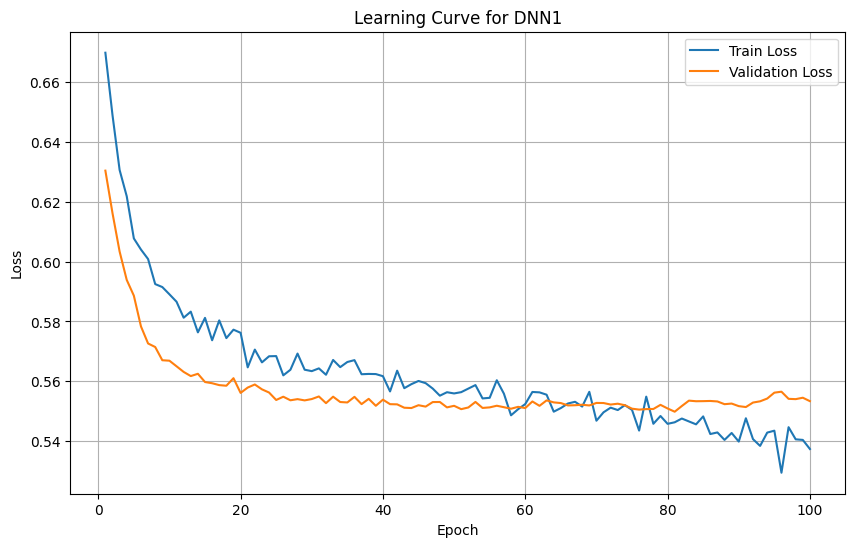

In [30]:
best_params=study.best_params
model = DNN_4(input_dim=X_train_tensor.shape[1],
              hidden_units1=best_params["hidden_units1"],
              hidden_units2=best_params["hidden_units2"],
              hidden_units3=best_params["hidden_units3"],
              hidden_units4=best_params["hidden_units4"],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              dropout3=best_params["dropout3"],
              dropout4=best_params["dropout4"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 61.28%
Precision: 0.4980
Recall: 0.3658
F1 Score: 0.4218
Matthews Correlation Coefficient: 0.1446
Specificity: 0.7681


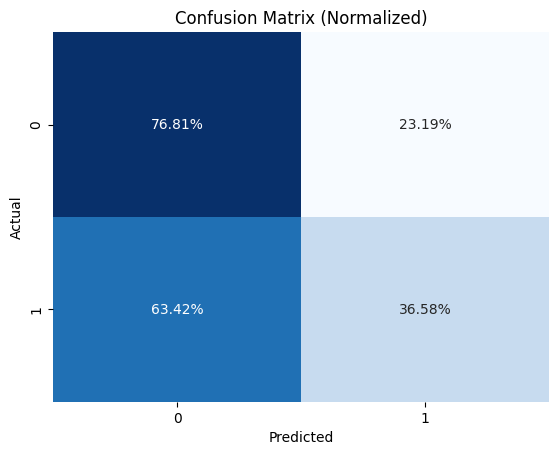

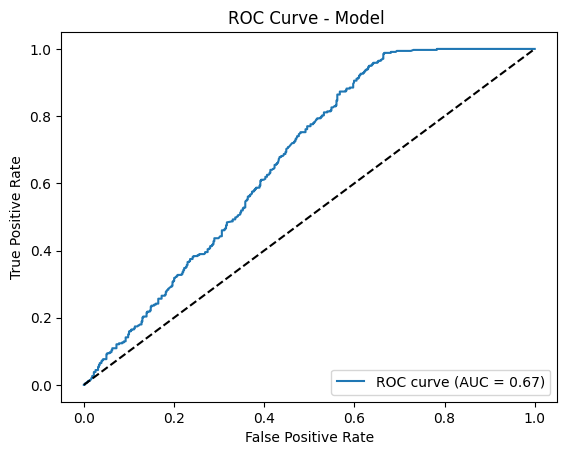

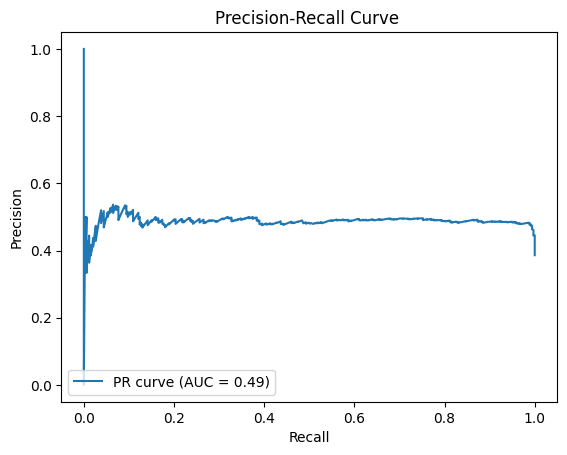

In [31]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [32]:
# モデルと構造を保存
torch.save(model, '../../saved_model/DNN_4.pth')
